In [19]:
import os, sys
import numpy as np
import ants
import argparse
import shutil
import logging
import subprocess
import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
import torchio as tio
import torch
from torchio.transforms import HistogramStandardization
import mpu.io

In [48]:
list_corrupted = ['1541_18_4', 'Patient_105215', '923_18', '423_18', '1769_18', 'Patient_130514',
                  '1170_18_4', 'Patient_89117','Patient_15817', 'Patient_1000314' ]
list_ok = os.listdir(base_dir)[:10]

In [65]:
base_dir = '/anvar/public_datasets/preproc_study/bgpd/4a_resamp/'

subjects_list = []
subjects_index = []
for patient in os.listdir(base_dir):
    subjects_index.append(patient)
    if os.path.isdir(base_dir + patient):
        subject = tio.Subject(
            t1 = tio.ScalarImage(base_dir + patient + '/T1.nii.gz'),
            t2 = tio.ScalarImage(base_dir + patient + '/T2.nii.gz'),
            # can be commented for other datasets
            ct1 = tio.ScalarImage(base_dir + patient + '/CT1.nii.gz'),
            fl = tio.ScalarImage(base_dir + patient + '/FLAIR.nii.gz'))

        subjects_list.append(subject)

# Create dataset
temp_t1_list = []
temp_t2_list = []
temp_ct1_list = []
temp_fl_list = []

for patient in os.listdir(base_dir):
    if os.path.isdir(base_dir + patient):

            subjects_list.append(subject)
            temp_t1_list.append(base_dir + patient + '/T1.nii.gz')
            temp_t2_list.append(base_dir + patient + '/T2.nii.gz')
            # can be commented for other datasets
            temp_ct1_list.append(base_dir + patient + '/CT1.nii.gz')
            temp_fl_list.append(base_dir + patient + '/FLAIR.nii.gz')


# Saving landmarks
landmarks_dict = torch.load('../../preprocessing/params/gbm_dict.pth')
hist_standardize = tio.HistogramStandardization(landmarks_dict)

## trying to train on all data

In [21]:
seed = mpu.io.read('../../preprocessing/params/bgpd_seed.json')

In [15]:
t1_landmarks = HistogramStandardization.train(temp_t1_list)
t2_landmarks = HistogramStandardization.train(temp_t2_list)
ct1_landmarks = HistogramStandardization.train(temp_ct1_list)
fl_landmarks = HistogramStandardization.train(temp_fl_list)

# Saving landmarks
landmarks_dict = {
't1': t1_landmarks,
't2': t2_landmarks,
'ct1': ct1_landmarks,
'fl': fl_landmarks
}

100%|██████████| 180/180 [02:58<00:00,  1.01it/s]


In [17]:
hist_standardize = tio.HistogramStandardization(landmarks_dict)

In [27]:
os.listdir(base_dir).index(list_corrupted[0])

167

In [28]:
subjects_list[os.listdir(base_dir).index(list_corrupted[0])]

Subject(Keys: ('t1', 't2', 'ct1', 'fl'); images: 4)

In [29]:
hist_standard = hist_standardize(subjects_list[os.listdir(base_dir).index(list_corrupted[0])])

In [33]:
hist_standard['t1']

ScalarImage(shape: (1, 240, 240, 132); spacing: (1.00, 1.00, 1.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 29.0 MiB)

In [38]:
old_img = ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/T1.nii.gz'.format(list_corrupted[0])
)
old_img

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (216, 240, 240)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-114.392, 91.1078, -108.0838)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

#### they have different dimentions

In [36]:
transform = tio.CropOrPad(old_img.shape)
transformed = transform(hist_standard['t1'])

In [37]:
transformed

ScalarImage(shape: (1, 216, 240, 240); spacing: (1.00, 1.00, 1.00); orientation: LAS+; dtype: torch.FloatTensor; memory: 47.5 MiB)

In [52]:
from dpipe.im.visualize import slice3d
slice3d(transformed.numpy()[0],
         old_img.numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=239), Output()), _dom…

#### Ok I will registrate them.

In [49]:
for i in range(0,5):
    print(ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/T1.nii.gz'.format(list_ok[i])))

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (265, 265, 168)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-127.4183, 155.3809, -84.7808)
	 Direction  : [ 0.9974 -0.0715  0.0015 -0.0712 -0.9945 -0.077  -0.007  -0.0767  0.997 ]

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 150)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-135.7811, 90.9899, -20.4127)
	 Direction  : [ 0.9918  0.1203  0.0423  0.1232 -0.9897 -0.0731 -0.0331 -0.0777  0.9964]

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (250, 250, 149)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-117.2209, 100.8868, -70.4355)
	 Direction  : [ 0.9965 -0.0748  0.0362 -0.077  -0.995   0.0639 -0.0313  0.0665  0.9973]

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (201, 230, 150)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-105.0105, 108.7295, -22.734)
	 Direction  : [ 1. -0.  0. -0. -1.  0. 

In [42]:
old_img = ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/T1.nii.gz'.format(list_corrupted[0])
)
new_img = ants.image_read('/anvar/public_datasets/preproc_study/bgpd/6_hist/6_hist_fold_0/{}/T1.nii.gz'.format(list_corrupted[0])
)

In [53]:
img_to_new = ants.registration(fixed=old_img, moving=new_img,
                                type_of_transform='Rigid')
new_registred = ants.apply_transforms(old_img, new_img,
                                        transformlist = img_to_new['fwdtransforms'][0])

In [54]:
slice3d(new_registred.numpy(),
         old_img.numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=239), Output()), _dom…

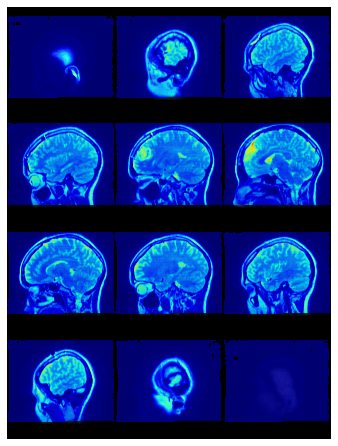

In [60]:
ants.plot(ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/T1.nii.gz'.format(list_corrupted[0])),
         ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/T2.nii.gz'.format(list_corrupted[0])))

In [61]:
slice3d(ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/T1.nii.gz'.format(list_corrupted[0])).numpy(),
         ants.image_read('/anvar/public_datasets/preproc_study/bgpd/4a_resamp/{}/T2.nii.gz'.format(list_corrupted[0])).numpy())

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=239), Output()), _dom…

In [68]:
list_corrupted[0]

'1541_18_4'

In [66]:
subjects_index.index()

['1360_18',
 'Patient_98817',
 'Patient_110816',
 '1421_18',
 '1357_19_4',
 'Patient_49617',
 'Patient_2914',
 'Patient_102117',
 'Patient_24117',
 '1470_18_4',
 'Patient_92114',
 'Patient_54317',
 'Patient_66615',
 '1302_18_4',
 'Patient_43316',
 '1635_18',
 'Patient_136715',
 'Patient_62817',
 'Patient_52315',
 '1463_18_4',
 'Patient_1000815',
 'Patient_70614',
 '558_18_4',
 '608_18_4',
 'Patient_33217',
 'Patient_111016',
 'Patient_12417',
 '705_18_4',
 'Patient_140316',
 'Patient_48417',
 '672_18_4',
 'Patient_75116',
 '1056_18_4',
 'Patient_88917',
 '875_18_4',
 '946_18',
 'Patient_76516',
 'Patient_161316',
 'Patient_90517',
 'Patient_24815',
 'Patient_90616',
 '688_18',
 '1326_18',
 'Patient_137315',
 '971_18_4',
 'Patient_109017',
 '1036_18',
 '1258_18',
 'Patient_103717',
 'Patient_69515',
 '1043_18_4',
 'Patient_129816',
 '1795_18_',
 'Patient_43515',
 'Patient_110014',
 '1743_18_4',
 'Patient_122315',
 '575_18_4',
 '607_18',
 '1029_18_4',
 'Patient_65516',
 'Patient_129316',

In [67]:
slice3d(subjects_list[subjects_index.index(list_corrupted[0])]['t1'].numpy()[0],
subjects_list[subjects_index.index(list_corrupted[0])]['t2'].numpy()[0])

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=131), Output()), _dom…

In [44]:
old_img

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (216, 240, 240)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-114.392, 91.1078, -108.0838)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [43]:
new_img

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (216, 240, 240)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-110.2765, 72.743, -107.1062)
	 Direction  : [ 1.000e+00  0.000e+00 -3.500e-03  8.000e-04 -9.720e-01  2.349e-01
  3.400e-03  2.349e-01  9.720e-01]

In [ ]:
 # hist standartize for the four landmarks
hist_standard = hist_standardize(subjects_list[])

hist_standard['t1'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/T1.nii.gz')
hist_standard['t2'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/T2.nii.gz')
hist_standard['ct1'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/CT1.nii.gz')
hist_standard['fl'].save(save_dir + '/6_hist_{}/'.format(fold) + os.listdir(base_dir)[i] +'/FLAIR.nii.gz')

In [7]:
ls ../../preprocessing/params/

bgpd_seed.json  gbm_seed.json               schw_seed.json
gbm_dict.pth    MNI152_T1_1mm_brain.nii.gz  sri24_T1.nii
